# Classification of Sleep Stages using ECG and Respiration Signals

The goal of this notebook is to demonstrate the classification of sleep stages using electrocardiogram (ECG) and respiration signals obtained from polysomnograph databases. This notebook includes (i) extraction of features from the physiological signals, (ii) selection of useful features, (iii) model training, and (iv) model selection. 

In [67]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.stats import skew, kurtosis
import itertools
import pickle
import glob
import seaborn as sns

import wfdb
from biosppy.signals import ecg
import nolds
import sampen

import sleep_utils as su

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

### Load MIT-BIH Polysomnographic Database
Database source: https://www.physionet.org/physiobank/database/slpdb/

In [3]:
data_dir = '../data/PSG_database/'

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

#### * Annotations*
   * W: subject is awake
   * 1: sleep stage 1
   * 2: sleep stage 2
   * 3: sleep stage 3
   * 4: sleep stage 4
   * R: REM sleep
   * MT: Movement time

In [4]:
# load labels 
ann_index = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index_sig = annotation[0]
    ann_label_sig = annotation[5]
    label_filt = [(x, y) for x, y in zip(ann_index_sig, ann_label_sig) if x >1 ]
    unzipped = zip(*label_filt)
    ann_index[key] = unzipped[0]
    ann_labels[key] = unzipped[1]


#### *Compile signals from different patients*

In [5]:
resp_data_set = {}
ecg_data_set = {}
bp_data_set = {}
time_data_set = {}
annot_data_set = {}

fs = 250

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('ECG')]
    bp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('BP')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages_list = [x.rsplit(' ')[0][0] for x in ann_labels[key]]

    annot_data_set[key] = stages_list


## I. Feature extraction

### *Features from Previous Stage*

In [26]:
feature_prev_stage = {}
feature_prev_stage_light = {}
feature_prev_stage_deep = {}
feature_prev_stage_rem = {}
feature_prev_stage_wake = {}
feature_prev_stage_move = {}

for key in data_keys:
    previous = annot_data_set[key][1:]
    prev_stage = [np.nan] + previous
    feature_prev_stage[key] = {'_feat' : prev_stage}
    
    # NREM-light or not
    feature_prev_stage_light[key] = [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)
    
    # NREM-deep or not
    feature_prev_stage_deep[key] = [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)
    
    # REM or not
    feature_prev_stage_rem[key] = [np.nan] + map(lambda x: 0 if x!= 'R' else 1,previous)
    
    # Wake or not
    feature_prev_stage_wake[key] = [np.nan] + map(lambda x: 0 if x!= 'W' else 1,previous)
    
    # Wake or not
    feature_prev_stage_move[key] = [np.nan] + map(lambda x: 0 if x!= 'M' else 1,previous)


*NOTE: Stages are annotated for every 30 seconds. The physiological signals will be divided into 30-second epochs/windows, and the features will be computed for every window. *

In [7]:
win_dur = 30 # duration of window, unit: seconds, size of one epoch 
win_size = fs*win_dur # length of window
win_step = 1 # duration by which the window slides, unit: seconds
win_int = win_step*fs # length by which the window slides

#### *Pre-process respiration signals and divide into 30-second epochs/windows*

In [8]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

resp_data_set_epochs = {}

# Divide respiration data per 30-second epoch. 

for key in data_keys:
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))
    time_sig = np.arange(len(resp_sig))/fs

    # Divide into windows
    resp_windows = su.divide_to_epochs(resp_filt_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    resp_data_set_epochs[key] = pd.DataFrame({'resp': list(resp_windows), '_time': list(time_windows)})


In [9]:
# Divide ECG data per 30-second epoch. 

ecg_data_set_epochs = {}

for key in data_keys:
    ecg_sig = ecg_data_set[key]
    time_sig = np.arange(len(ecg_sig))/fs

    # Divide into windows
    ecg_windows = su.divide_to_epochs(ecg_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    ecg_data_set_epochs[key] = pd.DataFrame({'ecg': list(ecg_windows), '_time': list(time_windows)})

### *Features from Respiration Signal*

1. Respiration rate (frequency corresponding to the highest peak in the epoch's power spectrum)
2. Mean magnitude
3. Minimum magnitude
4. Maximum magnitude 
5. Standard deviation of magnitudes
6. Ratio of standard deviation and mean of magnitude
7. Ratio of mean and standard deviation of peak-to-peak duration of respiration signal
8. Ratio of mean and standard deviation of amplitude of respiration signal
9. Ratio of max and mean of magnitude of amplitude of respiration signal
10. Ratio of min and mean of magnitude of amplitude of respiration 
11. Sample entropy of manitude of respiration signal
12. Number of zero crossings 
13. Kurtosis
14. Skew

In [10]:
feature_resp_rate = {}
feature_mean_mag_resp = {}
feature_min_mag_resp = {}
feature_max_mag_resp = {}
feature_stdev_mag_resp = {}
feature_std_vs_mean_resp = {}
feature_mean_vs_std_p2p_dur_resp = {}
feature_mean_vs_std_amp_resp = {}
feature_max_vs_mean_amp_resp = {}
feature_min_vs_mean_amp_resp = {}
feature_sampen_resp = {}
feature_zerocross_resp = {}
feature_kurtosis_resp = {}
feature_skew_resp = {}

for key in data_keys:
    resp_data = resp_data_set_epochs[key]
    resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
    
    # Respiration rate
    resp_data['resp_rate'] = resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60)
    feature_resp_rate[key] = resp_data.resp_rate.values
    
    # Mean of magnitudes
    feature_mean_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmean(x)).values

    # Minimum magnitude
    feature_min_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmin(x)).values

    # Maximum magnitude
    feature_max_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmax(x)).values
    
    # Standard deviation of magnitude
    feature_stdev_mag_resp[key] = resp_data.resp.apply(lambda x: np.std(x)).values
    
    # Mean vs standard deviation of magnitude
    feature_std_vs_mean_resp[key] = resp_data.resp.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values

    # Mean vs standard deviation of peak-to-peak duration
    p2p_dur = resp_data.resp.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'resp'))\
                            .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
    feature_mean_vs_std_p2p_dur_resp[key] = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values    

    # Mean vs stdev of amplitude of respiration signal
    amplitude = resp_data.resp.apply(lambda x: su.compute_amplitude(x, fs, 'resp'))
    feature_mean_vs_std_amp_resp[key] = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values
    
    # Max vs stdev of amplitude of respiration signal
    feature_max_vs_mean_amp_resp[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
    # Min vs stdev of amplitude of respiration signal
    feature_min_vs_mean_amp_resp[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
    # Sample entropy of respiration signal
    feature_sampen_resp[key] = resp_data.resp.apply(lambda x: (nolds.sampen(x))).values     
    
    # Number of zero crossings
    feature_zerocross_resp[key] = resp_data.resp.apply(lambda x: su.Zero_Crossing_Counts(x)).values     
    
    # Kurtosis
    feature_kurtosis_resp[key] = resp_data.resp.apply(lambda x: kurtosis(x)).values     
    
    # Skew
    feature_skew_resp[key] = resp_data.resp.apply(lambda x: skew(x)).values     
    
    print('Done computing features for ' + key + '.')


Done computing features for slp01a.
Done computing features for slp01b.
Done computing features for slp02a.
Done computing features for slp02b.
Done computing features for slp03.
Done computing features for slp04.
Done computing features for slp14.
Done computing features for slp16.


/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Done computing features for slp32.
Done computing features for slp37.
Done computing features for slp41.
Done computing features for slp45.
Done computing features for slp48.
Done computing features for slp59.
Done computing features for slp60.
Done computing features for slp61.
Done computing features for slp66.
Done computing features for slp67x.


### *Features from ECG Signal*

1. Heart rate
2. Heart rate variability
3. Mean magnitude
4. Minimum magnitude
5. Maximum magnitude 
6. Standard deviation of magnitudes
7. Ratio of standard deviation and mean of magnitude
8. Ratio of mean and standard deviation of peak-to-peak duration of ECG signal
9. Ratio of mean and standard deviation of amplitude of ECG signal
10. Ratio of max and mean of magnitude of amplitude of ECG signal
11. Ratio of min and mean of magnitude of amplitude of ECG signal
12. Sample entropy of manitude of ECG signal
13. Number of zero crossings 
14. Kurtosis
15. Skew

In [11]:
feature_heart_rate = {}
feature_heart_rate_var = {}
feature_mean_mag_ecg = {}
feature_min_mag_ecg = {}
feature_max_mag_ecg = {}
feature_stdev_mag_ecg = {}
feature_std_vs_mean_ecg = {}
feature_mean_vs_std_p2p_dur_ecg = {}
feature_mean_vs_std_amp_ecg = {}
feature_max_vs_mean_amp_ecg = {}
feature_min_vs_mean_amp_ecg = {}
feature_sampen_ecg = {}
feature_zerocross_ecg = {}
feature_kurtosis_ecg = {}
feature_skew_ecg = {}

for key in data_keys:
    ecg_data = ecg_data_set_epochs[key]
    
    # Get time corresponding to R peaks
    ecg_data['r_peaks'] = ecg_data.ecg.apply(lambda x: ecg.hamilton_segmenter(x, sampling_rate=250)['rpeaks'])
    ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
    # Heart rate
    feature_heart_rate[key] = ecg_data.r_time.apply(lambda x: su.heart_rate(np.array(x))*60).values
        
    # Heart rate variability
    feature_heart_rate_var[key] = ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000).values
    
    # Mean of magnitudes
    feature_mean_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmean(x)).values

    # Minimum magnitude
    feature_min_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmin(x)).values

    # Maximum magnitude
    feature_max_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmax(x)).values
    
    # Standard deviation of magnitude
    feature_stdev_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.std(x)).values
    
    # Mean vs standard deviation of magnitude
    feature_std_vs_mean_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values

    # Mean vs standard deviation of peak-to-peak duration
    p2p_dur = ecg_data.ecg.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'resp'))\
                          .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
    feature_mean_vs_std_p2p_dur_ecg[key] = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values    

    # Mean vs stdev of amplitude of respiration signal
    amplitude = ecg_data.ecg.apply(lambda x: su.compute_amplitude(x, fs, 'resp'))
    feature_mean_vs_std_amp_ecg[key] = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values
    
    # Max vs stdev of amplitude of respiration signal
    feature_max_vs_mean_amp_ecg[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
    # Min vs stdev of amplitude of respiration signal
    feature_min_vs_mean_amp_ecg[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
    # Sample entropy of respiration signal
    feature_sampen_ecg[key] = ecg_data.ecg.apply(lambda x: (nolds.sampen(x))).values     
    
    # Number of zero crossings
    feature_zerocross_ecg[key] = ecg_data.ecg.apply(lambda x: su.Zero_Crossing_Counts(x)).values     
    
    # Kurtosis
    feature_kurtosis_ecg[key] = ecg_data.ecg.apply(lambda x: kurtosis(x)).values     
    
    # Skew
    feature_skew_ecg[key] = ecg_data.ecg.apply(lambda x: skew(x)).values     
    
    print('Done computing features for ' + key + '.')


Done computing features for slp01a.
Done computing features for slp01b.
Done computing features for slp02a.
Done computing features for slp02b.
Done computing features for slp03.
Done computing features for slp04.
Done computing features for slp14.
Done computing features for slp16.
Done computing features for slp32.
Done computing features for slp37.
Done computing features for slp41.
Done computing features for slp45.
Done computing features for slp48.
Done computing features for slp59.
Done computing features for slp60.
Done computing features for slp61.
Done computing features for slp66.
Done computing features for slp67x.


#### *Save Features*

In [27]:
features_dir = data_dir + "compiled_features/"

# Previous stage

pickle.dump(feature_prev_stage, open(features_dir + "feature_prev_stage.pkl", "wb" ))
pickle.dump(feature_prev_stage_light, open(features_dir + "feature_prev_stage_light.pkl", "wb" ))
pickle.dump(feature_prev_stage_deep, open(features_dir + "feature_prev_stage_deep.pkl", "wb" ))
pickle.dump(feature_prev_stage_rem, open(features_dir + "feature_prev_stage_rem.pkl", "wb" ))
pickle.dump(feature_prev_stage_wake, open(features_dir + "feature_prev_stage_wake.pkl", "wb" ))
pickle.dump(feature_prev_stage_move, open(features_dir + "feature_prev_stage_move.pkl", "wb" ))


# Respiration

pickle.dump(feature_resp_rate, open(features_dir + "feature_resp_rate.pkl", "wb" ))
pickle.dump(feature_mean_mag_resp, open(features_dir + "feature_mean_mag_resp.pkl", "wb" ))
pickle.dump(feature_min_mag_resp, open(features_dir + "feature_min_mag_resp.pkl", "wb" ))
pickle.dump(feature_max_mag_resp, open(features_dir + "feature_max_mag_resp.pkl", "wb" ))
pickle.dump(feature_stdev_mag_resp, open(features_dir + "feature_stdev_mag_resp.pkl", "wb" ))
pickle.dump(feature_std_vs_mean_resp, open(features_dir + "feature_std_vs_mean_resp.pkl", "wb" ))
pickle.dump(feature_mean_vs_std_p2p_dur_resp, open(features_dir + "feature_mean_vs_std_p2p_dur_resp.pkl", "wb" ))
pickle.dump(feature_mean_vs_std_amp_resp, open(features_dir + "feature_mean_vs_std_amp_resp.pkl", "wb" ))
pickle.dump(feature_max_vs_mean_amp_resp, open(features_dir + "feature_max_vs_mean_amp_resp.pkl", "wb" ))
pickle.dump(feature_min_vs_mean_amp_resp, open(features_dir + "feature_min_vs_mean_amp_resp.pkl", "wb" ))
pickle.dump(feature_sampen_resp, open(features_dir + "feature_sampen_resp.pkl", "wb" ))
pickle.dump(feature_zerocross_resp, open(features_dir + "feature_zerocross_resp.pkl", "wb" ))
pickle.dump(feature_kurtosis_resp, open(features_dir + "feature_kurtosis_resp.pkl", "wb" ))
pickle.dump(feature_skew_resp, open(features_dir + "feature_skew_resp.pkl", "wb" ))

# ECG
pickle.dump(feature_heart_rate, open(features_dir + "feature_heart_rate.pkl", "wb" ))
pickle.dump(feature_heart_rate_var, open(features_dir + "feature_heart_rate_var.pkl", "wb" ))
pickle.dump(feature_mean_mag_ecg, open(features_dir + "feature_mean_mag_ecg.pkl", "wb" ))
pickle.dump(feature_min_mag_ecg, open(features_dir + "feature_min_mag_ecg.pkl", "wb" ))
pickle.dump(feature_max_mag_ecg, open(features_dir + "feature_max_mag_ecg.pkl", "wb" ))
pickle.dump(feature_stdev_mag_ecg, open(features_dir + "feature_stdev_mag_ecg.pkl", "wb" ))
pickle.dump(feature_std_vs_mean_ecg, open(features_dir + "feature_std_vs_mean_ecg.pkl", "wb" ))
pickle.dump(feature_mean_vs_std_p2p_dur_ecg, open(features_dir + "feature_mean_vs_std_p2p_dur_ecg.pkl", "wb" ))
pickle.dump(feature_mean_vs_std_amp_ecg, open(features_dir + "feature_mean_vs_std_amp_ecg.pkl", "wb" ))
pickle.dump(feature_max_vs_mean_amp_ecg, open(features_dir + "feature_max_vs_mean_amp_ecg.pkl", "wb" ))
pickle.dump(feature_min_vs_mean_amp_ecg, open(features_dir + "feature_min_vs_mean_amp_ecg.pkl", "wb" ))
pickle.dump(feature_sampen_ecg, open(features_dir + "feature_sampen_ecg.pkl", "wb" ))
pickle.dump(feature_zerocross_ecg, open(features_dir + "feature_zerocross_ecg.pkl", "wb" ))
pickle.dump(feature_kurtosis_ecg, open(features_dir + "feature_kurtosis_ecg.pkl", "wb" ))
pickle.dump(feature_skew_ecg, open(features_dir + "feature_skew_ecg.pkl", "wb" ))


#### *Collate Features*

In [35]:
physio_features = [feature_resp_rate, feature_mean_mag_resp, feature_min_mag_resp,
                   feature_max_mag_resp, feature_stdev_mag_resp, feature_std_vs_mean_resp, 
                   feature_mean_vs_std_p2p_dur_resp, feature_mean_vs_std_amp_resp, feature_max_vs_mean_amp_resp, 
                   feature_min_vs_mean_amp_resp, feature_sampen_resp, feature_zerocross_resp, 
                   feature_kurtosis_resp, feature_skew_resp, 
                   feature_heart_rate, feature_heart_rate_var, feature_mean_mag_ecg, 
                   feature_min_mag_ecg, feature_max_mag_ecg, feature_stdev_mag_ecg, 
                   feature_std_vs_mean_ecg, feature_mean_vs_std_p2p_dur_ecg, feature_mean_vs_std_amp_ecg, 
                   feature_max_vs_mean_amp_ecg, feature_min_vs_mean_amp_ecg, feature_sampen_ecg, 
                   feature_zerocross_ecg, feature_kurtosis_ecg, feature_skew_ecg]

all_features = physio_features+ [feature_prev_stage_light, feature_prev_stage_deep, 
                                 feature_prev_stage_rem, feature_prev_stage_wake, feature_prev_stage_move]


f_merge_physio = []
f_merge_all = []

for f in physio_features:
    fm = []
    for key in data_keys:
        fm += list(f[key])
    f_merge_physio.append(np.reshape(fm, [len(fm), -1]))
    
for f in all_features:
    fm = []
    for key in data_keys:
        fm += list(f[key])
    f_merge_all.append(np.reshape(fm, [len(fm), -1]))
    
sleep_features_physio = np.hstack(f_merge_physio)
sleep_features_all = np.hstack(f_merge_all)


In [37]:
merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

merge_labels[np.where(merge_labels == '1')] = 1
merge_labels[np.where(merge_labels == '2')] = 2
merge_labels[np.where(merge_labels == '3')] = 3
merge_labels[np.where(merge_labels == '4')] = 3
merge_labels[np.where(merge_labels == 'R')] = 4
merge_labels[np.where(merge_labels == 'W')] = 5
merge_labels[np.where(merge_labels == 'M')] = 6

In [41]:
## features from physiological signals only
sleep_features_physio = np.array(sleep_features_physio, dtype = float)
sleep_data_physio = sleep_features_physio[np.isfinite(sleep_features_physio).all(axis=1)]
sleep_labels_physio = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features_physio).all(axis=1)]

## features from physiological signals and previous stage
sleep_features_all = np.array(sleep_features_all, dtype = float)
sleep_data_all = sleep_features_all[np.isfinite(sleep_features_all).all(axis=1)]
sleep_labels_all = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features_all).all(axis=1)]

#### *Get training and test set*


In [42]:
sleep_data_scaled_physio = StandardScaler().fit_transform(sleep_data_physio)
train_set_physio, test_set_physio, train_label_physio, test_label_physio = train_test_split(sleep_data_scaled_physio, sleep_labels_physio, test_size=0.33, random_state=42)

train_label_physio = np.ndarray.flatten(train_label_physio).astype(float)
test_label_physio = np.ndarray.flatten(test_label_physio).astype(float)

In [43]:
sleep_data_scaled_all = StandardScaler().fit_transform(sleep_data_all)
train_set_all, test_set_all, train_label_all, test_label_all = train_test_split(sleep_data_scaled_all, sleep_labels_all, test_size=0.33, random_state=42)

train_label_all = np.ndarray.flatten(train_label_all).astype(float)
test_label_all = np.ndarray.flatten(test_label_all).astype(float)

## II. Feature selection


### *Selection of features from physiological signals alone (Unbalanced data)*

In [74]:
classifiers = [DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
               SVC(kernel="linear", C=0.025)]

names = ["Decision Tree", "Random Forest", "Linear SVM"]


Decision Tree
Optimal number of features : 12
Maximum accuracy : 0.550122%
Selected features: [ 0  7 13 14 15 16 17 18 20 24 25 28]


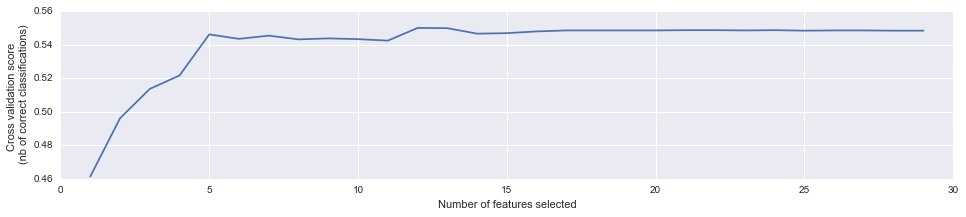

Random Forest
Optimal number of features : 9
Maximum accuracy : 0.658987%
Selected features: [ 0 14 16 18 20 25 26 27 28]


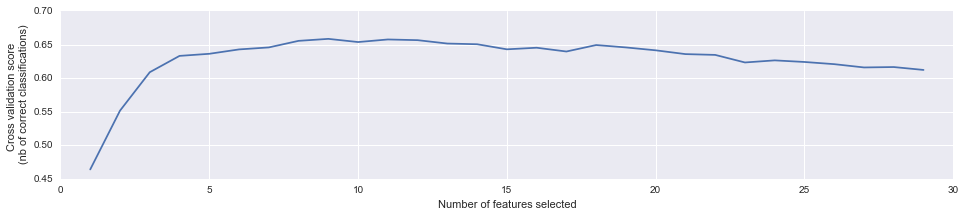

Linear SVM
Optimal number of features : 27
Maximum accuracy : 0.535097%
Selected features: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 28]


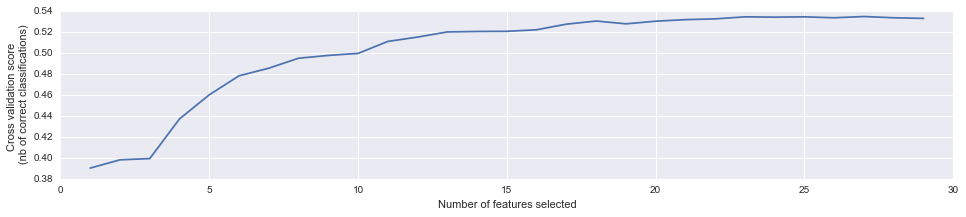

In [75]:
selected_features_physio = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set_physio, train_label_physio)
    selected_features_physio[names[i]] = np.arange(train_set_physio.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_physio[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=[16, 3])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

### *Selection from all extracted features  (Unbalanced data)*

Decision Tree
Optimal number of features : 4
Maximum accuracy : 0.854737%
Selected features: [16 29 31 32]


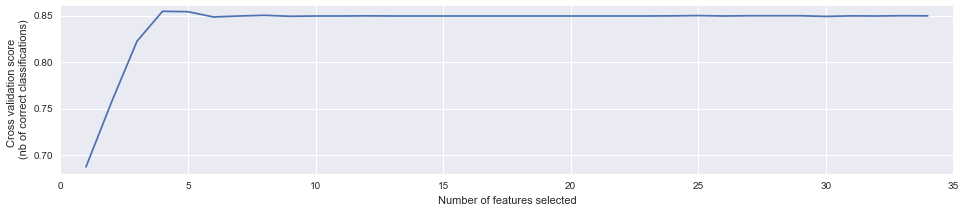

Random Forest
Optimal number of features : 11
Maximum accuracy : 0.872764%
Selected features: [ 2 16 17 19 20 25 27 29 30 31 32]


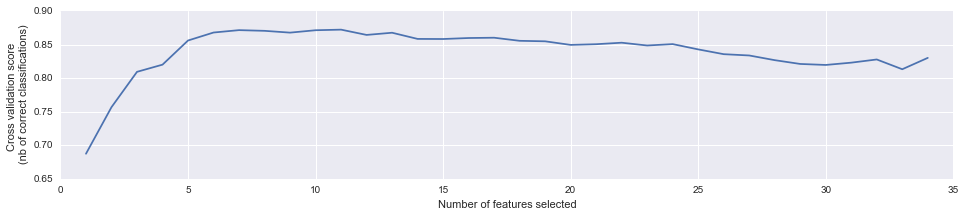

Linear SVM
Optimal number of features : 31
Maximum accuracy : 0.826579%
Selected features: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30 31 32 33]


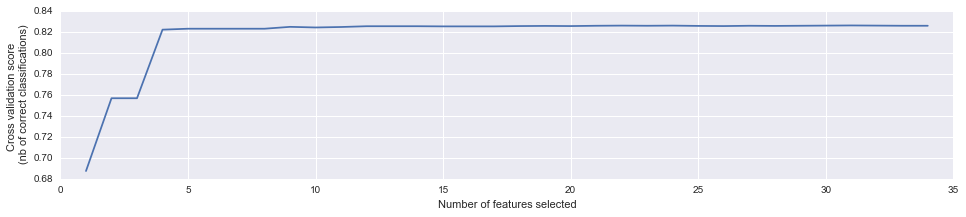

In [76]:
selected_features_all = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set_all, train_label_all)
    selected_features_all[names[i]] = np.arange(train_set_all.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_all[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=[16, 3])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

### *Selection of features from physiological signals alone (Balanced data)*

In [77]:
oversample_data_physio, oversample_label_physio = su.smote_all_minority(train_set_physio, train_label_physio)
train_set_smote_physio = []
train_label_smote_physio = []

for k in oversample_data_physio.keys():
    train_set_smote_physio.append(oversample_data_physio[k])
    train_label_smote_physio.append(oversample_label_physio[k])
    
train_set_smote_physio = np.vstack(train_set_smote_physio)
train_label_smote_physio = np.hstack(train_label_smote_physio)

Decision Tree
Optimal number of features : 28
Maximum accuracy : 0.548976%
Selected features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28]


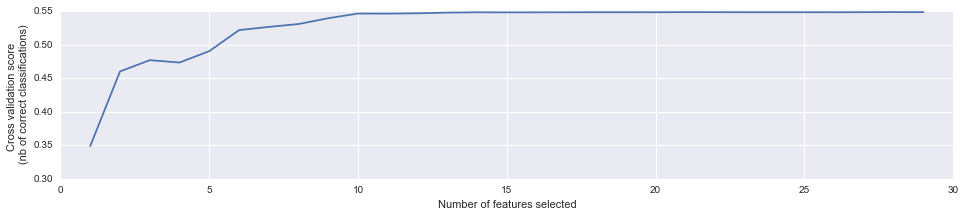

Random Forest
Optimal number of features : 20
Maximum accuracy : 0.797007%
Selected features: [ 0  2  3  4  7 10 11 12 13 14 16 17 18 19 20 24 25 26 27 28]


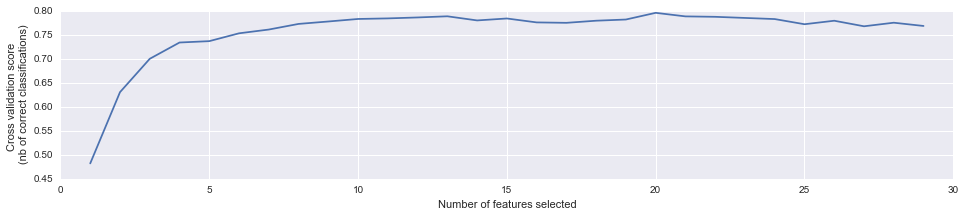

Linear SVM
Optimal number of features : 29
Maximum accuracy : 0.580540%
Selected features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


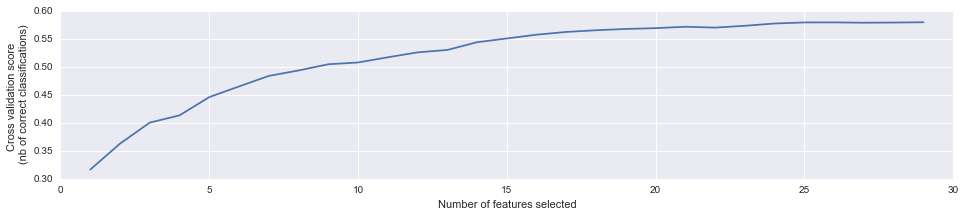

In [78]:
selected_features_smote_physio = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set_smote_physio, train_label_smote_physio)
    selected_features_smote_physio[names[i]] = np.arange(train_set_smote_physio.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_smote_physio[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=[16, 3])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

### *Selection from all extracted features (Balanced data)*

In [79]:
oversample_data_all, oversample_label_all = su.smote_all_minority(train_set_all, train_label_all)
train_set_smote_all = []
train_label_smote_all = []

for k in oversample_data_all.keys():
    train_set_smote_all.append(oversample_data_all[k])
    train_label_smote_all.append(oversample_label_all[k])
    
train_set_smote_all = np.vstack(train_set_smote_all)
train_label_smote_all = np.hstack(train_label_smote_all)

Decision Tree
Optimal number of features : 28
Maximum accuracy : 0.916286%
Selected features: [ 4  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27 28 29 30
 31 32 33]


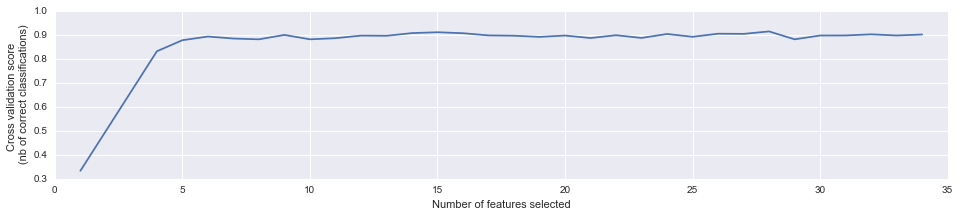

Random Forest
Optimal number of features : 14
Maximum accuracy : 0.930556%
Selected features: [ 2  8 16 17 18 19 20 22 25 29 30 31 32 33]


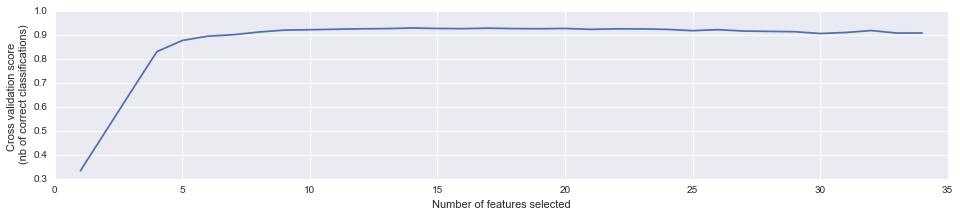

Linear SVM
Optimal number of features : 30
Maximum accuracy : 0.899607%
Selected features: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27 28
 29 30 31 32 33]


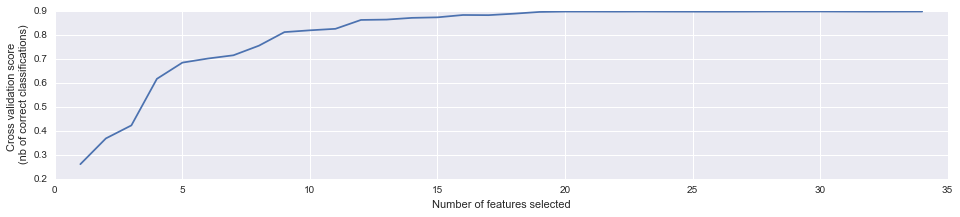

In [80]:
selected_features_smote_all = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set_smote_all, train_label_smote_all)
    selected_features_smote_all[names[i]] = np.arange(train_set_smote_all.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_smote_all[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=[16, 3])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()